<a href="https://colab.research.google.com/github/jfink09/DeepFundus/blob/main/Copy_of_DeepFundus_eightclasses.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
######################################################### Use block of code if dataset is on GitHub #######################################################
# import os
# import requests
# import zipfile
# from pathlib import Path

# # Setup path to data folder
# data_path = Path("data/")
# image_path = data_path / "deepfundus"

# # If the image folder doesn't exist, download it and prepare it... 
# if image_path.is_dir():
#     print(f"{image_path} directory exists.")
# else:
#     print(f"Did not find {image_path} directory, creating one...")
#     image_path.mkdir(parents=True, exist_ok=True)

# # Download fundus data
# with open(data_path / "deepfundus.zip", "wb") as f:
#     request = requests.get("https://github.com/jfink09/DeepFundus/raw/main/deepfundus.zip")
#     print("Downloading fundus data...")
#     f.write(request.content)

# # Unzip fundus data
# with zipfile.ZipFile(data_path / "deepfundus.zip", "r") as zip_ref:
#     print("Unzipping fundus data...") 
#     zip_ref.extractall(image_path)

# # Remove zip file
# os.remove(data_path / "deepfundus.zip")

In [ ]:
######################################### Use commented out code if dataset was downloaded from GitHub ######################################################
# # Setup train and testing paths
# train_dir = image_path / "train"
# test_dir = image_path / "test"

# train_dir, test_dir
from pathlib import Path

In [ ]:
# Setup train and testing paths
train_dir = Path("drive/MyDrive/data/train")
test_dir = Path("drive/MyDrive/data/test")

train_dir, test_dir

(PosixPath('drive/MyDrive/data/train'), PosixPath('drive/MyDrive/data/test'))

In [ ]:
from torchvision import datasets, transforms

# Create simple transform
data_transform = transforms.Compose([ 
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])

# Use ImageFolder to create dataset(s)
train_data = datasets.ImageFolder(root=train_dir, # target folder of images
                                  transform=data_transform, # transforms to perform on data (images)
                                  target_transform=None) # transforms to perform on labels (if necessary)

test_data = datasets.ImageFolder(root=test_dir, 
                                 transform=data_transform)

print(f"Train data:\n{train_data}\nTest data:\n{test_data}")

Train data:
Dataset ImageFolder
    Number of datapoints: 815
    Root location: drive/MyDrive/data/train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
           )
Test data:
Dataset ImageFolder
    Number of datapoints: 204
    Root location: drive/MyDrive/data/test
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
           )


In [ ]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

torch version: 1.13.1+cu116
torchvision version: 0.14.1+cu116


In [ ]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular scripts... downloading them from GitHub.")
    !git clone https://github.com/jfink09/optical-funduscopic-convolutional-neural-network
    !mv optical-funduscopic-convolutional-neural-network/going_modular .
    !rm -rf optical-funduscopic-convolutional-neural-network
    from going_modular.going_modular import data_setup, engine

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular scripts... downloading them from GitHub.
Cloning into 'optical-funduscopic-convolutional-neural-network'...
remote: Enumerating objects: 260, done.
remote: Counting objects: 100% (188/188), done.
remote: Compressing objects: 100% (147/147), done.
remote: Total 260 (delta 92), reused 90 (delta 40), pack-reused 72
Receiving objects: 100% (260/260), 110.85 MiB | 16.94 MiB/s, done.
Resolving deltas: 100% (107/107), done.


In [ ]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

In [ ]:
# Create a transforms pipeline manually (required for torchvision < 0.13)
manual_transforms = transforms.Compose([
    transforms.Resize((224, 224)), # 1. Reshape all images to 224x224 (though some models may require different sizes)
    transforms.ToTensor(), # 2. Turn image values to between 0 & 1 
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # 3. A mean of [0.485, 0.456, 0.406] (across each colour channel)
                         std=[0.229, 0.224, 0.225]) # 4. A standard deviation of [0.229, 0.224, 0.225] (across each colour channel),
])

In [ ]:
# Create training and testing DataLoaders as well as get a list of class names
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=manual_transforms, # resize, convert images to between 0 & 1 and normalize them
                                                                               batch_size=32) # set mini-batch size to 32

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7f39d1029880>,
 ['CRVO',
  'Diabetic Retinopathy',
  'Laser Spots',
  'Macular Degeneration',
  'Myelinated Nerve Fiber',
  'Normal',
  'Pathological Mypoia',
  'Retinitis Pigmentosa'])

In [ ]:
# Get a set of pretrained model weights
weights = torchvision.models.EfficientNet_B7_Weights.DEFAULT # .DEFAULT = best available weights from pretraining on ImageNet
weights

EfficientNet_B7_Weights.IMAGENET1K_V1

In [ ]:
# Get the transforms used to create our pretrained weights
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[600]
    resize_size=[600]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [ ]:
# # Create training and testing DataLoaders as well as get a list of class names
# train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
#                                                                                test_dir=test_dir,
#                                                                                transform=auto_transforms, # perform same data transforms on our own data as the pretrained model
#                                                                                batch_size=32) # set mini-batch size to 32

# train_dataloader, test_dataloader, class_names

In [ ]:
# OLD: Setup the model with pretrained weights and send it to the target device (this was prior to torchvision v0.13)
# model = torchvision.models.efficientnet_b0(pretrained=True).to(device) # OLD method (with pretrained=True)

# NEW: Setup the model with pretrained weights and send it to the target device (torchvision v0.13+)
weights = torchvision.models.EfficientNet_B7_Weights.DEFAULT # .DEFAULT = best available weights 
model = torchvision.models.efficientnet_b7(weights=weights).to(device)

#model # uncomment to output (it's very long)

Downloading: "https://download.pytorch.org/models/efficientnet_b7_lukemelas-dcc49843.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b7_lukemelas-dcc49843.pth


  0%|          | 0.00/255M [00:00<?, ?B/s]

In [ ]:
# Print a summary using torchinfo (uncomment for actual output)
summary(model=model,
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 1000]           --                   True
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 2560, 7, 7]     --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 64, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 64, 112, 112]   1,728                True
│    │    └─BatchNorm2d (1)                                  [32, 64, 112, 112]   [32, 64, 112, 112]   128                  True
│    │    └─SiLU (2)                                         [32, 64, 112, 112]   [32, 64, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 64, 112, 112]   [32, 32, 112

In [ ]:
# Freeze all base layers in the "features" section of the model (the feature extractor) by setting requires_grad=False
for param in model.features.parameters():
    param.requires_grad = False

In [ ]:
# Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Get the length of class_names (one output unit for each class)
output_shape = len(class_names)

# Recreate the classifier layer and seed it to the target device
model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True), 
    torch.nn.Linear(in_features=2560, 
                    out_features=output_shape, # same number of output units as our number of classes
                    bias=True)).to(device)

In [ ]:
# # Do a summary *after* freezing the features and changing the output classifier layer (uncomment for actual output)
summary(model, 
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape" (batch_size, color_channels, height, width)
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 8]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 2560, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 64, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 64, 112, 112]   (1,728)              False
│    │    └─BatchNorm2d (1)                                  [32, 64, 112, 112]   [32, 64, 112, 112]   (128)                False
│    │    └─SiLU (2)                                         [32, 64, 112, 112]   [32, 64, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 64, 112, 112]   [32, 

In [ ]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Setup training and save the results
results = engine.train(model=model,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=10,
                        device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.7467 | train_acc: 0.4484 | test_loss: 1.8136 | test_acc: 0.2976
Epoch: 2 | train_loss: 1.2403 | train_acc: 0.6594 | test_loss: 1.6067 | test_acc: 0.4628
Epoch: 3 | train_loss: 1.0265 | train_acc: 0.7118 | test_loss: 1.4120 | test_acc: 0.5580
Epoch: 4 | train_loss: 0.8743 | train_acc: 0.7817 | test_loss: 1.2936 | test_acc: 0.6071
Epoch: 5 | train_loss: 0.7941 | train_acc: 0.7985 | test_loss: 1.2183 | test_acc: 0.6265
Epoch: 6 | train_loss: 0.6881 | train_acc: 0.8302 | test_loss: 1.1714 | test_acc: 0.6399
Epoch: 7 | train_loss: 0.6572 | train_acc: 0.8275 | test_loss: 1.1455 | test_acc: 0.6443
Epoch: 8 | train_loss: 0.6181 | train_acc: 0.8434 | test_loss: 1.1174 | test_acc: 0.6443
Epoch: 9 | train_loss: 0.5667 | train_acc: 0.8556 | test_loss: 1.0755 | test_acc: 0.6562
Epoch: 10 | train_loss: 0.5222 | train_acc: 0.8822 | test_loss: 1.0584 | test_acc: 0.6607
[INFO] Total training time: 1042.068 seconds


In [ ]:
# Get the plot_loss_curves() function from helper_functions.py, download the file if we don't have it
try:
    from helper_functions import plot_loss_curves
except:
    print("[INFO] Couldn't find helper_functions.py, downloading...")
    with open("helper_functions.py", "wb") as f:
        import requests
        request = requests.get("https://github.com/jfink09/optical-funduscopic-convolutional-neural-network/raw/main/helper_functions.py")
        f.write(request.content)
    from helper_functions import plot_loss_curves

# Plot the loss curves of our model
plot_loss_curves(results)

In [ ]:
from typing import List, Tuple

from PIL import Image

# 1. Take in a trained model, class names, image path, image size, a transform and target device
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str, 
                        class_names: List[str],
                        image_size: Tuple[int, int] = (224, 224),
                        transform: torchvision.transforms = None,
                        device: torch.device=device):
    
    
    # 2. Open image
    img = Image.open(image_path)

    # 3. Create transformation for image (if one doesn't exist)
    if transform is not None:
        image_transform = transform
    else:
        image_transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),
        ])

    ### Predict on image ### 

    # 4. Make sure the model is on the target device
    model.to(device)

    # 5. Turn on model evaluation mode and inference mode
    model.eval()
    with torch.inference_mode():
      # 6. Transform and add an extra dimension to image (model requires samples in [batch_size, color_channels, height, width])
      transformed_image = image_transform(img).unsqueeze(dim=0)

      # 7. Make a prediction on image with an extra dimension and send it to the target device
      target_image_pred = model(transformed_image.to(device))

    # 8. Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # 9. Convert prediction probabilities -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    # 10. Plot image with predicted label and probability 
    plt.figure()
    plt.imshow(img)
    plt.title(f"Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f}")
    plt.axis(False);

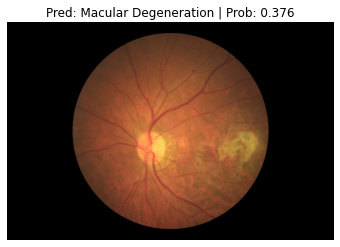

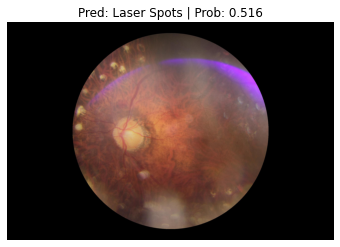

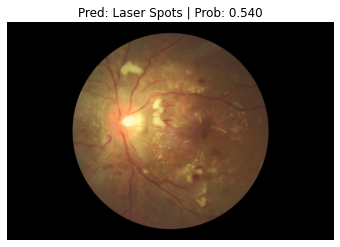

In [ ]:
# Get a random list of image paths from test set
import random
num_images_to_plot = 3
test_image_path_list = list(Path(test_dir).glob("*/*.jpg")) # get list all image paths from test data 
test_image_path_sample = random.sample(population=test_image_path_list, # go through all of the test image paths
                                       k=num_images_to_plot) # randomly select 'k' image paths to pred and plot

# Make predictions on and plot the images
for image_path in test_image_path_sample:
    pred_and_plot_image(model=model, 
                        image_path=image_path,
                        class_names=class_names,
                        # transform=weights.transforms(), # optionally pass in a specified transform from our pretrained model weights
                        image_size=(224, 224))

In [ ]:
data_path = Path("data/")
image_path = data_path / "deepfundus"

# If the image folder doesn't exist, download it and prepare it... 
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

Did not find data/deepfundus directory, creating one...


In [ ]:
################################################### Not needed ################################################
# # Download custom image
# import requests

# # Setup custom image path
# custom_image_path = data_path / "pm256.jpg"

# # Download the image if it doesn't already exist
# if not custom_image_path.is_file():
#     with open(custom_image_path, "wb") as f:
#         # When downloading from GitHub, need to use the "raw" file link
#         #request = requests.get("https://github.com/jfink09/optical-funduscopic-convolutional-neural-network/raw/main/images/dr100.jpg")
#         #request = requests.get("https://github.com/jfink09/optical-funduscopic-convolutional-neural-network/raw/main/images/normal61.jpg")
#         request = requests.get("https://github.com/jfink09/DeepFundus/raw/main/images/pm256.jpg")
#         print(f"Downloading {custom_image_path}...")
#         f.write(request.content)
# else:
#     print(f"{custom_image_path} already exists, skipping download.")

# # Predict on custom image
# pred_and_plot_image(model=model,
#                     image_path=custom_image_path,
#                     class_names=class_names)

In [ ]:
# Import/install Gradio 
try:
    import gradio as gr
except: 
    !pip -q install gradio
    import gradio as gr
    
print(f"Gradio version: {gr.__version__}")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.2/14.2 MB 81.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 KB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 77.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.5/71.5 KB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.5/84.5 KB 11.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.0/107.0 KB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 18.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 KB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.3/64.3 KB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.6/80.6 KB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.6/69.6 KB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Put EffNetB0 on CPU
model.to("cpu") 

# Check the device
next(iter(model.parameters())).device

device(type='cpu')

In [ ]:
# 1. Setup pretrained EffNetB0 weights
effnetb7_weights = torchvision.models.EfficientNet_B7_Weights.DEFAULT

# 2. Get EffNetB0 transforms
effnetb7_transforms = effnetb7_weights.transforms()

# 3. Setup pretrained model
effnetb7 = torchvision.models.efficientnet_b7(weights=effnetb7_weights) # could also use weights="DEFAULT"

# 4. Freeze the base layers in the model (this will freeze all layers to begin with)
for param in effnetb7.parameters():
    param.requires_grad = False

In [ ]:
# Check out EffNetB0 classifier head
effnetb7.classifier

Sequential(
  (0): Dropout(p=0.5, inplace=True)
  (1): Linear(in_features=2560, out_features=1000, bias=True)
)

In [ ]:
# 5. Update the classifier head
effnetb7.classifier = nn.Sequential(
    nn.Dropout(p=0.3, inplace=True), # keep dropout layer same
    nn.Linear(in_features=2560, # keep in_features same 
              out_features=8)) # change out_features to suit our number of classes # 4

In [ ]:
def create_effnetb7_model(num_classes:int=8, # 4
                          seed:int=42):
    """Creates an EfficientNetB0 feature extractor model and transforms.

    Args:
        num_classes (int, optional): number of classes in the classifier head. 
            Defaults to 3.
        seed (int, optional): random seed value. Defaults to 42.

    Returns:
        model (torch.nn.Module): EffNetB2 feature extractor model. 
        transforms (torchvision.transforms): EffNetB0 image transforms.
    """
    # 1, 2, 3. Create EffNetB0 pretrained weights, transforms and model
    weights = torchvision.models.EfficientNet_B7_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.efficientnet_b7(weights=weights)

    # 4. Freeze all layers in base model
    for param in model.parameters():
        param.requires_grad = False

    # 5. Change classifier head with random seed for reproducibility
    torch.manual_seed(seed)
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3, inplace=True),
        nn.Linear(in_features=2560
                  , out_features=num_classes), # If using EffnetB2 in_features = 1408, EffnetB0 in_features = 1280
    )
    
    return model, transforms

In [ ]:
effnetb7, effnetb7_transforms = create_effnetb7_model(num_classes=8, # 4
                                                      seed=42)

In [ ]:
from torchinfo import summary

# Print EffNetB0 model summary (uncomment for full output) 
summary(effnetb7, 
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 8]               --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 2560, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 64, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 64, 112, 112]    (1,728)              False
│    │    └─BatchNorm2d (1)                                  [1, 64, 112, 112]    [1, 64, 112, 112]    (128)                False
│    │    └─SiLU (2)                                         [1, 64, 112, 112]    [1, 64, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 64, 112, 112]    [1, 3

In [ ]:
# Setup DataLoaders
from going_modular.going_modular import data_setup
train_dataloader_effnetb7, test_dataloader_effnetb7, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                                 test_dir=test_dir,
                                                                                                 transform=effnetb7_transforms,
                                                                                                 batch_size=32)

In [ ]:
from going_modular.going_modular import engine

# Setup optimizer
optimizer = torch.optim.Adam(params=effnetb7.parameters(),
                             lr=1e-3)
# Setup loss function
loss_fn = torch.nn.CrossEntropyLoss()

# Set seeds for reproducibility and train the model
#set_seeds()
effnetb7_results = engine.train(model=effnetb7,
                                train_dataloader=train_dataloader_effnetb7,
                                test_dataloader=test_dataloader_effnetb7,
                                epochs=20,
                                optimizer=optimizer,
                                loss_fn=loss_fn,
                                device=device)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1550 | train_acc: 0.7143 | test_loss: 1.8461 | test_acc: 0.2976
Epoch: 2 | train_loss: 0.9028 | train_acc: 0.7808 | test_loss: 1.6429 | test_acc: 0.4330
Epoch: 3 | train_loss: 0.7836 | train_acc: 0.8093 | test_loss: 1.3524 | test_acc: 0.5625
Epoch: 4 | train_loss: 0.6710 | train_acc: 0.8481 | test_loss: 1.1311 | test_acc: 0.6860
Epoch: 5 | train_loss: 0.6158 | train_acc: 0.8553 | test_loss: 0.9967 | test_acc: 0.7262
Epoch: 6 | train_loss: 0.5554 | train_acc: 0.8646 | test_loss: 0.9078 | test_acc: 0.7723
Epoch: 7 | train_loss: 0.5024 | train_acc: 0.8917 | test_loss: 0.8529 | test_acc: 0.7812
Epoch: 8 | train_loss: 0.4708 | train_acc: 0.8951 | test_loss: 0.8160 | test_acc: 0.7812
Epoch: 9 | train_loss: 0.4485 | train_acc: 0.8977 | test_loss: 0.7786 | test_acc: 0.7768
Epoch: 10 | train_loss: 0.4128 | train_acc: 0.9219 | test_loss: 0.7713 | test_acc: 0.7768
Epoch: 11 | train_loss: 0.3827 | train_acc: 0.9181 | test_loss: 0.7601 | test_acc: 0.7679
Epoch: 12 | train_l

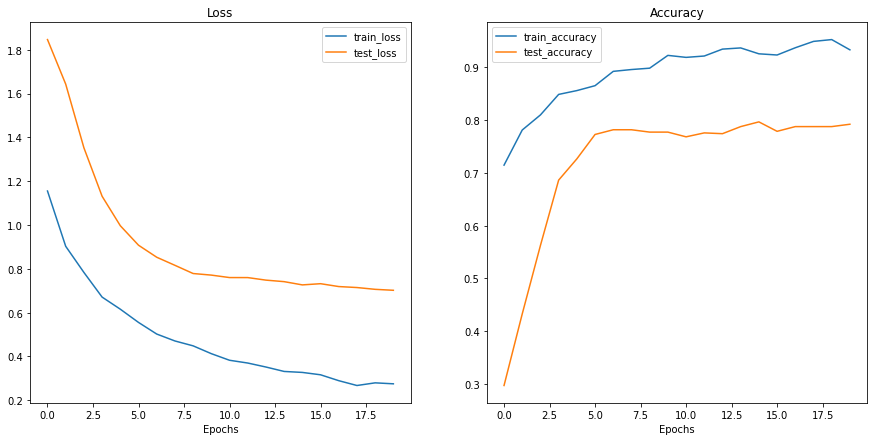

In [ ]:
from helper_functions import plot_loss_curves

plot_loss_curves(effnetb7_results)

In [ ]:
from going_modular.going_modular import utils

# Save the model
utils.save_model(model=effnetb7,
                 target_dir="models",
                 model_name="pretrained_effnetb0_feature_extractor_drappcompressed.pth")

[INFO] Saving model to: models/pretrained_effnetb0_feature_extractor_drappcompressed.pth


In [ ]:
from pathlib import Path

# Get the model size in bytes then convert to megabytes
pretrained_effnetb7_model_size = Path("models/pretrained_effnetb0_feature_extractor_drappcompressed.pth").stat().st_size // (1024*1024) # division converts bytes to megabytes (roughly) 
print(f"Pretrained EffNetB0 feature extractor model size: {pretrained_effnetb7_model_size} MB")

Pretrained EffNetB0 feature extractor model size: 245 MB


In [ ]:
# Count number of parameters in EffNetB0
effnetb7_total_params = sum(torch.numel(param) for param in effnetb7.parameters())
effnetb7_total_params

63807448

In [ ]:
# Create a dictionary with EffNetB0 statistics
effnetb7_stats = {"test_loss": effnetb7_results["test_loss"][-1],
                  "test_acc": effnetb7_results["test_acc"][-1],
                  "number_of_parameters": effnetb7_total_params,
                  "model_size (MB)": pretrained_effnetb7_model_size}
effnetb7_stats

{'test_loss': 0.7020437717437744,
 'test_acc': 0.7916666666666667,
 'number_of_parameters': 63807448,
 'model_size (MB)': 245}

In [ ]:
from pathlib import Path

# Get all test data paths
print(f"[INFO] Finding all filepaths ending with '.jpg' in directory: {test_dir}")
test_data_paths = list(Path(test_dir).glob("*/*.jpg"))
test_data_paths[:5]

[INFO] Finding all filepaths ending with '.jpg' in directory: drive/MyDrive/data/test


[PosixPath('drive/MyDrive/data/test/Normal/normal93.jpg'),
 PosixPath('drive/MyDrive/data/test/Normal/normal86.jpg'),
 PosixPath('drive/MyDrive/data/test/Normal/normal89.jpg'),
 PosixPath('drive/MyDrive/data/test/Normal/normal83.jpg'),
 PosixPath('drive/MyDrive/data/test/Normal/normal88.jpg')]

In [ ]:
import pathlib
import torch

from PIL import Image
from timeit import default_timer as timer 
from tqdm.auto import tqdm
from typing import List, Dict

# 1. Create a function to return a list of dictionaries with sample, truth label, prediction, prediction probability and prediction time
def pred_and_store(paths: List[pathlib.Path], 
                   model: torch.nn.Module,
                   transform: torchvision.transforms, 
                   class_names: List[str], 
                   device: str = "cuda" if torch.cuda.is_available() else "cpu") -> List[Dict]:
    
    # 2. Create an empty list to store prediction dictionaires
    pred_list = []
    
    # 3. Loop through target paths
    for path in tqdm(paths):
        
        # 4. Create empty dictionary to store prediction information for each sample
        pred_dict = {}

        # 5. Get the sample path and ground truth class name
        pred_dict["image_path"] = path
        class_name = path.parent.stem
        pred_dict["class_name"] = class_name
        
        # 6. Start the prediction timer
        start_time = timer()
        
        # 7. Open image path
        img = Image.open(path).convert('RGB')
        
        # 8. Transform the image, add batch dimension and put image on target device
        transformed_image = transform(img).unsqueeze(0).to(device) 
        
        # 9. Prepare model for inference by sending it to target device and turning on eval() mode
        model.to(device)
        model.eval()
        
        # 10. Get prediction probability, predicition label and prediction class
        with torch.inference_mode():
            pred_logit = model(transformed_image) # perform inference on target sample 
            pred_prob = torch.softmax(pred_logit, dim=1) # turn logits into prediction probabilities
            pred_label = torch.argmax(pred_prob, dim=1) # turn prediction probabilities into prediction label
            pred_class = class_names[pred_label.cpu()] # hardcode prediction class to be on CPU

            # 11. Make sure things in the dictionary are on CPU (required for inspecting predictions later on) 
            pred_dict["pred_prob"] = round(pred_prob.unsqueeze(0).max().cpu().item(), 4)
            pred_dict["pred_class"] = pred_class
            
            # 12. End the timer and calculate time per pred
            end_time = timer()
            pred_dict["time_for_pred"] = round(end_time-start_time, 4)

        # 13. Does the pred match the true label?
        pred_dict["correct"] = class_name == pred_class

        # 14. Add the dictionary to the list of preds
        pred_list.append(pred_dict)
    
    # 15. Return list of prediction dictionaries
    return pred_list

In [ ]:
# Make predictions across test dataset with EffNetB0
effnetb7_test_pred_dicts = pred_and_store(paths=test_data_paths,
                                          model=effnetb7,
                                          transform=effnetb7_transforms,
                                          class_names=class_names,
                                          device="cpu") # make predictions on CPU 

  0%|          | 0/204 [00:00<?, ?it/s]

In [ ]:
# Inspect the first 2 prediction dictionaries
effnetb7_test_pred_dicts[:2]

[{'image_path': PosixPath('drive/MyDrive/data/test/Normal/normal93.jpg'),
  'class_name': 'Normal',
  'pred_prob': 0.9983,
  'pred_class': 'Normal',
  'time_for_pred': 1.9455,
  'correct': True},
 {'image_path': PosixPath('drive/MyDrive/data/test/Normal/normal86.jpg'),
  'class_name': 'Normal',
  'pred_prob': 0.9879,
  'pred_class': 'Normal',
  'time_for_pred': 1.6585,
  'correct': True}]

In [ ]:
# Turn the test_pred_dicts into a DataFrame
import pandas as pd
effnetb7_test_pred_df = pd.DataFrame(effnetb7_test_pred_dicts)
effnetb7_test_pred_df.head()

,image_path,class_name,pred_prob,pred_class,time_for_pred,correct
0,drive/MyDrive/data/test/Normal/normal93.jpg,Normal,0.9983,Normal,1.9455,True
1,drive/MyDrive/data/test/Normal/normal86.jpg,Normal,0.9879,Normal,1.6585,True
2,drive/MyDrive/data/test/Normal/normal89.jpg,Normal,0.9902,Normal,1.6430,True
3,drive/MyDrive/data/test/Normal/normal83.jpg,Normal,0.9039,Normal,1.7962,True
4,drive/MyDrive/data/test/Normal/normal88.jpg,Normal,0.9975,Normal,1.6492,True


In [ ]:
# Check number of correct predictions
effnetb7_test_pred_df.correct.value_counts()

True     116
False     88
Name: correct, dtype: int64

In [ ]:
# Find the average time per prediction 
effnetb7_average_time_per_pred = round(effnetb7_test_pred_df.time_for_pred.mean(), 4)
print(f"EffNetB0 average time per prediction: {effnetb7_average_time_per_pred} seconds")

EffNetB0 average time per prediction: 1.6944 seconds


In [ ]:
# Add EffNetB0 average prediction time to stats dictionary 
effnetb7_stats["time_per_pred_cpu"] = effnetb7_average_time_per_pred
effnetb7_stats

{'test_loss': 0.7020437717437744,
 'test_acc': 0.7916666666666667,
 'number_of_parameters': 63807448,
 'model_size (MB)': 245,
 'time_per_pred_cpu': 1.6944}

In [ ]:
# Turn stat dictionaries into DataFrame
df = pd.DataFrame([effnetb7_stats])

# Add column for model names
df["model"] = ["EffNetB0"]

# Convert accuracy to percentages
df["test_acc"] = round(df["test_acc"] * 100, 2)

df

,test_loss,test_acc,number_of_parameters,model_size (MB),time_per_pred_cpu,model
0,0.702044,79.17,63807448,245,1.6944,EffNetB0


In [ ]:
# Put EffNetB0 on CPU
effnetb7.to("cpu") 

# Check the device
next(iter(effnetb7.parameters())).device

device(type='cpu')

In [ ]:
from typing import Tuple, Dict

def predict(img) -> Tuple[Dict, float]:
    """Transforms and performs a prediction on img and returns prediction and time taken.
    """
    # Start the timer
    start_time = timer()
    
    # Transform the target image and add a batch dimension
    img = effnetb7_transforms(img).unsqueeze(0)
    
    # Put model into evaluation mode and turn on inference mode
    effnetb7.eval()
    with torch.inference_mode():
        # Pass the transformed image through the model and turn the prediction logits into prediction probabilities
        pred_probs = torch.softmax(effnetb7(img), dim=1)
    
    # Create a prediction label and prediction probability dictionary for each prediction class (this is the required format for Gradio's output parameter)
    pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}
    
    # Calculate the prediction time
    pred_time = round(timer() - start_time, 5)
    
    # Return the prediction dictionary and prediction time 
    return pred_labels_and_probs, pred_time

In [ ]:
import random
from PIL import Image

# Get a list of all test image filepaths
test_data_paths = list(Path(test_dir).glob("*/*.jpg"))

# Randomly select a test image path
random_image_path = random.sample(test_data_paths, k=1)[0]

# Open the target image
image = Image.open(random_image_path)
print(f"[INFO] Predicting on image at path: {random_image_path}\n")

# Predict on the target image and print out the outputs
pred_dict, pred_time = predict(img=image)
print(f"Prediction label and probability dictionary: \n{pred_dict}")
print(f"Prediction time: {pred_time} seconds")

[INFO] Predicting on image at path: drive/MyDrive/data/test/Macular Degeneration/mdegen228.jpg

Prediction label and probability dictionary: 
{'CRVO': 0.001017333590425551, 'Diabetic Retinopathy': 0.00613947119563818, 'Laser Spots': 0.05336802452802658, 'Macular Degeneration': 0.8603484034538269, 'Myelinated Nerve Fiber': 0.07030155509710312, 'Normal': 0.001360430964268744, 'Pathological Mypoia': 0.004458004608750343, 'Retinitis Pigmentosa': 0.0030066748149693012}
Prediction time: 1.64753 seconds


In [ ]:
# Create a list of example inputs to our Gradio demo
example_list = [[str(filepath)] for filepath in random.sample(test_data_paths, k=4)]
example_list

[['drive/MyDrive/data/test/Retinitis Pigmentosa/rp32.jpg'],
 ['drive/MyDrive/data/test/Macular Degeneration/mdegen271.jpg'],
 ['drive/MyDrive/data/test/Pathological Myopia/pm218.jpg'],
 ['drive/MyDrive/data/test/CRVO/crvo31.jpg']]

In [ ]:
import gradio as gr

# Create title, description and article strings
title = "DeepFundus 👀"
description = "An EfficientNetB7 feature extractor computer vision model to classify retina pathology from optical funduscopic images."
article = "Created for fun."

# Create the Gradio demo
demo = gr.Interface(fn=predict, # mapping function from input to output
                    inputs=gr.Image(type="pil"), # what are the inputs?
                    outputs=[gr.Label(num_top_classes=8, label="Predictions"), # what are the outputs?
                             gr.Number(label="Prediction time (s)")], # our fn has two outputs, therefore we have two outputs
                    examples=example_list, 
                    title=title,
                    description=description,
                    article=article)

# Launch the demo!
demo.launch(debug=False, # print errors locally?
            share=True) # generate a publically shareable URL?

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://06062bf4-3f6d-44ab.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades (NEW!), check out Spaces: https://huggingface.co/spaces
